In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from datetime import timedelta
import pytz


In [4]:
df = pd.read_csv("manual_harvest_data.csv")
df = df.rename(columns={"Date":"date", "Tank ID":"tank_id", "Before Harvest (kg)":"before", "After Harvest (kg)":"after", "Removed (kg)":"removed", "Comments":"comments"})
df["datetime"] = pd.to_datetime(df.date)
df.head()

,date,tank_id,before,after,removed,comments,Unnamed: 6,datetime
0,3.9.23,1,52.10,22.11,29.99,NaN,NaN,2023-03-09
1,3.9.23,2,0.00,0.00,0.00,Remained Empty,NaN,2023-03-09
2,3.9.23,3,51.81,0.00,51.81,Empty,NaN,2023-03-09
3,3.9.23,4,NaN,NaN,32.20,NaN,NaN,2023-03-09
4,3.9.23,5,NaN,NaN,22.70,NaN,NaN,2023-03-09


In [10]:
sub_df = df[df.tank_id == 7].copy()

restocks = np.array(sub_df[(sub_df.after == 22.11) & (sub_df.before == 0)].datetime, dtype='datetime64[s]')
empties = np.array(sub_df[sub_df.before > 0].datetime, dtype='datetime64[s]')

time_delta = empties[-1] - restocks[-1]
days = (time_delta / 60 / 60 / 24).astype('int') - 1

start_mass = sub_df[sub_df.datetime == restocks[-1]].after.values[0]
end_mass = sub_df[sub_df.datetime == empties[-1]].before.values[0]
removed_mass = sub_df[(sub_df.removed > 0) & (sub_df.datetime > restocks[-1]) & (sub_df.datetime < empties[-1])].removed.values.sum()

mass_per_day = ((end_mass + removed_mass - start_mass)/days)

print(days)
print(start_mass)
print(end_mass)
print(removed_mass)

print(mass_per_day)

27
22.11
67.21
46.9
3.407407407407407


In [11]:
start_date = restocks[-1].astype(datetime) + timedelta(hours=11)
end_date = empties[-1].astype(datetime) + timedelta(hours=11)

date_range = [start_date + timedelta(hours=24*i) for i in range(days + 1)]

algae_mass = np.zeros(len(date_range))
algae_mass[0] = start_mass
algae_mass[-1] = end_mass

for i in range(len(date_range) - 1):
   day_vals = sub_df[(date_range[i] - sub_df.datetime) == np.timedelta64(11, 'h')]
   removed = day_vals.removed.values
   if (i > 0):
      algae_mass[i] = algae_mass[i-1] + mass_per_day
      if removed.any():
         algae_mass[i] -= removed[0]

for i in range(len(date_range)):
   print(date_range[i], algae_mass[i])

2023-04-13 11:00:00 22.11
2023-04-14 11:00:00 25.517407407407408
2023-04-15 11:00:00 28.924814814814816
2023-04-16 11:00:00 32.33222222222222
2023-04-17 11:00:00 35.739629629629626
2023-04-18 11:00:00 39.14703703703703
2023-04-19 11:00:00 42.554444444444435
2023-04-20 11:00:00 45.96185185185184
2023-04-21 11:00:00 49.369259259259245
2023-04-22 11:00:00 52.77666666666665
2023-04-23 11:00:00 56.184074074074054
2023-04-24 11:00:00 59.59148148148146
2023-04-25 11:00:00 62.998888888888864
2023-04-26 11:00:00 66.40629629629628
2023-04-27 11:00:00 22.913703703703682
2023-04-28 11:00:00 26.32111111111109
2023-04-29 11:00:00 29.7285185185185
2023-04-30 11:00:00 33.1359259259259
2023-05-01 11:00:00 36.54333333333331
2023-05-02 11:00:00 39.95074074074071
2023-05-03 11:00:00 43.35814814814812
2023-05-04 11:00:00 46.76555555555552
2023-05-05 11:00:00 50.17296296296293
2023-05-06 11:00:00 53.58037037037033
2023-05-07 11:00:00 56.98777777777774
2023-05-08 11:00:00 60.39518518518514
2023-05-09 11:00:0

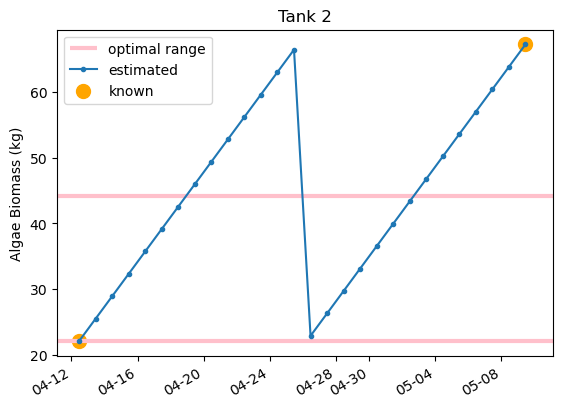

In [12]:
# Set date format for x-axis labels
date_fmt = '%m-%d'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt, tz=(pytz.timezone("US/Eastern")))


lower = datetime(2023, 4, 11, hour=23)
lower = pytz.timezone("US/Eastern").localize(lower)
upper = datetime(2023, 5, 11, hour=23)
upper = pytz.timezone("US/Eastern").localize(upper)

plt.figure()
plt.hlines([22.11, 44.22], 19_000, 20_000, color='pink', linewidth=3)
plt.plot(date_range, algae_mass, marker='.')
plt.scatter([date_range[0], date_range[-1]], [algae_mass[0], algae_mass[-1]], s=100, color='orange')
plt.legend(['optimal range','estimated', 'known', ])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.ylabel("Algae Biomass (kg)")
plt.title("Tank 2")
plt.xlim(lower, upper)
plt.savefig("harvest_data_2.png")
plt.show()

In [93]:
empty = np.zeros(len(algae_mass))

output_dict = {'date': date_range, 'tank1' : empty, 'tank2' : algae_mass, 'tank3' : empty, 'tank4' : empty, 'tank5' : empty,
               'tank6': empty, 'tank7': empty, 'tank8': empty}

output_df = pd.DataFrame(data=output_dict)

In [98]:
start = output_df.index[output_df.date == date_range[0]]
end = output_df.index[output_df.date == date_range[-1]]

print(start, end)
output_df.loc[start[0]:end[0], 'tank7'] = algae_mass

output_df.head()

Int64Index([28], dtype='int64') Int64Index([41], dtype='int64')


,date,tank1,tank2,tank3,tank4,tank5,tank6,tank7,tank8
0,2023-03-16 11:00:00,0.0,22.110000,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-17 11:00:00,0.0,25.614878,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-18 11:00:00,0.0,29.119756,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-19 11:00:00,0.0,32.624634,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-03-20 11:00:00,0.0,36.129512,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
output_df.to_csv('harvest_data.csv')